In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

tf.random.set_seed(42)

(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

X_valid, X_test, y_valid, y_test = train_test_split(
    X_test, y_test, test_size=0.2, random_state=42
)

X_train, X_test, X_valid = [x / 255.0 for x in (X_train, X_test, X_valid)]

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_valid)}")
print(f"Test set size: {len(X_test)}")


Training set size: 50000
Validation set size: 8000
Test set size: 2000


# Эксперимент 1

In [4]:
from tqdm import tqdm

def load_imgs(imgs):
    """
    This function returns two random quarters of the image.
    """
    inputs_first, inputs_second, outputs = [], [], []
    sec_coords = [[[0, 32], [0, 32]], [[0, 32], [32, 64]], [[32, 64], [0, 32]], [[32, 64], [32, 64]]]
    for img in tqdm(imgs):
        sect = [0, 1, 2, 3]
        img = tf.image.resize(img, [64, 64])
        sect1 = np.random.choice(sect)
        sect.remove(sect1)
        sect2 = np.random.choice(sect)
        first_img = img[sec_coords[sect1][0][0]:sec_coords[sect1][0][1], sec_coords[sect1][1][0]:sec_coords[sect1][1][1]]
        second_img = img[sec_coords[sect2][0][0]:sec_coords[sect2][0][1], sec_coords[sect2][1][0]:sec_coords[sect2][1][1]]
        inputs_first.append(first_img)
        inputs_second.append(second_img)
        outputs.append(sect2)

    return np.array(inputs_first), np.array(inputs_second), keras.utils.to_categorical(outputs, 4)


In [5]:
train_first, train_second, train_outputs = load_imgs(X_train)
valid_first, valid_second, valid_outputs = load_imgs(X_valid)

100%|█████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:09<00:00, 856.08it/s]


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, Dense, Input, Concatenate

backbone = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D((2, 2)),
    Dropout(0.25),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D((2, 2)),
])

In [9]:
inputs1 = Input(shape=(32, 32, 3), name='first_img')
inputs2 = Input(shape=(32, 32, 3), name='second_img')
backbone1 = backbone(inputs1)
backbone2 = backbone(inputs2)
concatenated = Concatenate()([Flatten()(backbone1), Flatten()(backbone2)])
x = Dense(1024, activation='relu')(concatenated)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(4, activation='softmax', name='Output')(x)

ssl_model = keras.Model(inputs=[inputs1, inputs2], outputs=outputs)

# Compile the SSL model
ssl_model.compile(optimizer=keras.optimizers.Adam(0.0005),
                  loss="categorical_crossentropy",
                  metrics=[keras.metrics.CategoricalAccuracy(), 
                           keras.metrics.Precision(),
                           keras.metrics.Recall()])

In [11]:
ssl_model.fit({'first_img': train_first, 'second_img': train_second},
              train_outputs,
              validation_data=({'first_img': valid_first, 'second_img': valid_second}, valid_outputs),
              batch_size=256,
              epochs=50)

Epoch 1/50
196/196 [==============================] - 5s 25ms/step - loss: 1.1920 - categorical_accuracy: 0.5333 - precision: 0.6474 - recall: 0.3769 - val_loss: 1.6722 - val_categorical_accuracy: 0.3233 - val_precision: 0.3518 - val_recall: 0.2733
Epoch 2/50
196/196 [==============================] - 4s 23ms/step - loss: 0.7366 - categorical_accuracy: 0.7052 - precision: 0.7683 - recall: 0.6282 - val_loss: 0.6492 - val_categorical_accuracy: 0.7450 - val_precision: 0.7879 - val_recall: 0.6980
Epoch 3/50
196/196 [==============================] - 4s 22ms/step - loss: 0.5669 - categorical_accuracy: 0.7761 - precision: 0.8168 - recall: 0.7323 - val_loss: 0.4474 - val_categorical_accuracy: 0.8218 - val_precision: 0.8436 - val_recall: 0.8044
Epoch 4/50
196/196 [==============================] - 4s 22ms/step - loss: 0.4084 - categorical_accuracy: 0.8384 - precision: 0.8584 - recall: 0.8178 - val_loss: 0.3254 - val_categorical_accuracy: 0.8728 - val_precision: 0.8855 - val_recall: 0.8600
Epoc

Epoch 34/50
196/196 [==============================] - 5s 24ms/step - loss: 0.0251 - categorical_accuracy: 0.9910 - precision: 0.9915 - recall: 0.9907 - val_loss: 0.0460 - val_categorical_accuracy: 0.9821 - val_precision: 0.9829 - val_recall: 0.9819
Epoch 35/50
196/196 [==============================] - 5s 23ms/step - loss: 0.0217 - categorical_accuracy: 0.9922 - precision: 0.9926 - recall: 0.9920 - val_loss: 0.0662 - val_categorical_accuracy: 0.9800 - val_precision: 0.9811 - val_recall: 0.9794
Epoch 36/50
196/196 [==============================] - 4s 23ms/step - loss: 0.0282 - categorical_accuracy: 0.9904 - precision: 0.9906 - recall: 0.9901 - val_loss: 0.0581 - val_categorical_accuracy: 0.9811 - val_precision: 0.9819 - val_recall: 0.9808
Epoch 37/50
196/196 [==============================] - 5s 23ms/step - loss: 0.0283 - categorical_accuracy: 0.9903 - precision: 0.9907 - recall: 0.9902 - val_loss: 0.0618 - val_categorical_accuracy: 0.9799 - val_precision: 0.9805 - val_recall: 0.9789


In [13]:
import os

backbone.save_weights('weights/backbone')

os.makedirs('weights', exist_ok=True)

In [14]:
y_train = keras.utils.to_categorical(y_train, 10)
y_valid = keras.utils.to_categorical(y_valid, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [15]:
def prepare_dataset(X, y):
    X_dataset = tf.data.Dataset.from_tensor_slices(X)
    y_dataset = tf.data.Dataset.from_tensor_slices(y)
    dataset = tf.data.Dataset.zip((X_dataset, y_dataset))
    return dataset.shuffle(500).batch(256).prefetch(tf.data.experimental.AUTOTUNE)

dataset_train = prepare_dataset(X_train, y_train)
dataset_valid = prepare_dataset(X_valid, y_valid)
dataset_test = prepare_dataset(X_test, y_test)

In [16]:
backbone.load_weights('weights/backbone')

In [17]:
inputs = keras.Input(shape=(32, 32, 3))
x = backbone(inputs, training=False)  # Set training to False to use the backbone as a feature extractor
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(128, activation="relu", name='Dense_1')(x)
x = keras.layers.Dropout(0.25)(x)
output = keras.layers.Dense(10, activation='softmax', name='Output')(x)

first_model = keras.models.Model(inputs=inputs, outputs=output)

first_model.compile(optimizer=keras.optimizers.Adam(0.0005),
                    loss="categorical_crossentropy",
                    metrics=['accuracy',  # Replaced F1 as it's not a standard metric in Keras
                             keras.metrics.Precision(name='precision_1'),
                             keras.metrics.Recall(name='recall_1')])

In [18]:
learn_rate_red = keras.callbacks.ReduceLROnPlateau("val_loss", patience=3, factor=0.5, min_lr=1e-6)
early_stop = keras.callbacks.EarlyStopping("val_loss", patience=6)
tensorboard = tf.keras.callbacks.TensorBoard(log_dir="logs/Exp_1")

history_1 = first_model.fit(dataset_train,
                            validation_data=dataset_valid,
                            epochs=50,
                            callbacks=[learn_rate_red, early_stop, tensorboard])

Epoch 1/50
196/196 [==============================] - 3s 13ms/step - loss: 1.6746 - accuracy: 0.4240 - precision_1: 0.6334 - recall_1: 0.2364 - val_loss: 1.1923 - val_accuracy: 0.5705 - val_precision_1: 0.7211 - val_recall_1: 0.4231 - lr: 5.0000e-04
Epoch 2/50
196/196 [==============================] - 2s 12ms/step - loss: 1.1079 - accuracy: 0.6119 - precision_1: 0.7517 - recall_1: 0.4742 - val_loss: 1.0046 - val_accuracy: 0.6401 - val_precision_1: 0.7597 - val_recall_1: 0.5235 - lr: 5.0000e-04
Epoch 3/50
196/196 [==============================] - 2s 12ms/step - loss: 0.9095 - accuracy: 0.6807 - precision_1: 0.7942 - recall_1: 0.5706 - val_loss: 0.9390 - val_accuracy: 0.6718 - val_precision_1: 0.7731 - val_recall_1: 0.5821 - lr: 5.0000e-04
Epoch 4/50
196/196 [==============================] - 2s 12ms/step - loss: 0.7674 - accuracy: 0.7318 - precision_1: 0.8240 - recall_1: 0.6415 - val_loss: 0.8677 - val_accuracy: 0.6959 - val_precision_1: 0.7777 - val_recall_1: 0.6273 - lr: 5.0000e-04


8/8 [==============================] - 0s 7ms/step - loss: 1.0147 - accuracy: 0.7310 - precision_1: 0.7537 - recall_1: 0.7100
Eval_loss = 1.014699935913086
Eval_precision = 0.7310000061988831
Eval_recall = 0.7537155151367188
Eval_accuracy = 0.7100000381469727


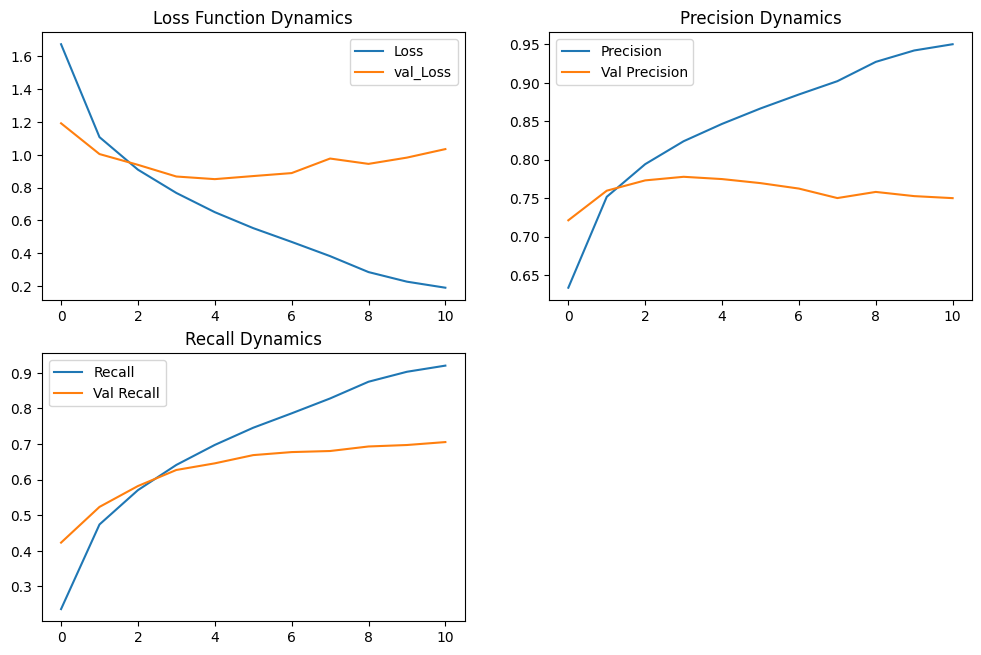

In [20]:
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt

eval_hist_1 = first_model.evaluate(dataset_test)

print(f"Eval_loss = {eval_hist_1[0]}")
print(f"Eval_precision = {eval_hist_1[1]}")
print(f"Eval_recall = {eval_hist_1[2]}")
print(f"Eval_accuracy = {eval_hist_1[3]}")

plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(history_1.history['loss'], label='Loss')
plt.plot(history_1.history['val_loss'], label='val_Loss')
plt.title('Loss Function Dynamics')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(history_1.history['precision_1'], label='Precision')
plt.plot(history_1.history['val_precision_1'], label='Val Precision')
plt.title('Precision Dynamics')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(history_1.history['recall_1'], label='Recall')
plt.plot(history_1.history['val_recall_1'], label='Val Recall')
plt.title('Recall Dynamics')
plt.legend()

plt.show()


In [21]:
preds = first_model.predict(X_test)
preds = np.argmax(preds, axis=1)
y_test_idx = np.argmax(y_test, axis=1)

print(classification_report(y_test_idx, preds))

63/63 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.72      0.82      0.77       187
           1       0.89      0.82      0.85       189
           2       0.64      0.61      0.63       201
           3       0.55      0.51      0.53       198
           4       0.63      0.67      0.65       181
           5       0.60      0.63      0.62       191
           6       0.79      0.80      0.80       213
           7       0.79      0.75      0.77       226
           8       0.88      0.80      0.84       203
           9       0.81      0.87      0.84       211

    accuracy                           0.73      2000
   macro avg       0.73      0.73      0.73      2000
weighted avg       0.73      0.73      0.73      2000



# Эксперимент 2

In [22]:
dataset_train_2 = dataset_train.shard(num_shards=2, index=0)

backbone.load_weights('weights/backbone')

In [24]:
from tensorflow.keras.models import Model

inputs = Input(shape=(32, 32, 3))
x = backbone(inputs, training=False)  # Указываем, что backbone не обучается
x = Flatten()(x)
x = Dense(128, activation="relu", name='Dense_1')(x)
x = Dropout(0.25)(x)
output = Dense(10, activation='softmax', name='Output')(x)

second_model = Model(inputs=inputs, outputs=output)

In [25]:
second_model.compile(optimizer=keras.optimizers.Adam(0.0005),
                     loss="categorical_crossentropy",
                     metrics=['accuracy',
                              keras.metrics.Precision(name='precision_2'),
                              keras.metrics.Recall(name='recall_2')])

In [28]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard

learn_rate_red = ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5, min_lr=1e-6)
early_stop = EarlyStopping(monitor="val_loss", patience=6)
tensorboard = TensorBoard(log_dir="logs/Exp_2")

history_2 = second_model.fit(dataset_train_2,
                             validation_data=dataset_valid,
                             epochs=50,
                             callbacks=[learn_rate_red, early_stop, tensorboard])

Epoch 1/50
98/98 [==============================] - 3s 16ms/step - loss: 1.9778 - accuracy: 0.3397 - precision_2: 0.5307 - recall_2: 0.1298 - val_loss: 1.4260 - val_accuracy: 0.4771 - val_precision_2: 0.6844 - val_recall_2: 0.2700 - lr: 5.0000e-04
Epoch 2/50
98/98 [==============================] - 1s 14ms/step - loss: 1.3401 - accuracy: 0.5240 - precision_2: 0.6971 - recall_2: 0.3469 - val_loss: 1.1847 - val_accuracy: 0.5806 - val_precision_2: 0.7332 - val_recall_2: 0.4130 - lr: 5.0000e-04
Epoch 3/50
98/98 [==============================] - 1s 13ms/step - loss: 1.1506 - accuracy: 0.5932 - precision_2: 0.7381 - recall_2: 0.4471 - val_loss: 1.0776 - val_accuracy: 0.6146 - val_precision_2: 0.7593 - val_recall_2: 0.4776 - lr: 5.0000e-04
Epoch 4/50
98/98 [==============================] - 1s 13ms/step - loss: 1.0342 - accuracy: 0.6355 - precision_2: 0.7672 - recall_2: 0.5048 - val_loss: 1.0133 - val_accuracy: 0.6401 - val_precision_2: 0.7634 - val_recall_2: 0.5139 - lr: 5.0000e-04
Epoch 5/

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

eval_hist_2 = second_model.evaluate(dataset_test)

print(f"Eval_loss = {eval_hist_2[0]}")
print(f"Eval_precision = {eval_hist_2[1]}")
print(f"Eval_recall = {eval_hist_2[2]}")
print(f"Eval_accuracy = {eval_hist_2[3]}")

8/8 [==============================] - 0s 6ms/step - loss: 0.9286 - accuracy: 0.7145 - precision_2: 0.7586 - recall_2: 0.6865
Eval_loss = 0.9286348223686218
Eval_precision = 0.7145000100135803
Eval_recall = 0.7585635781288147
Eval_accuracy = 0.6865000128746033


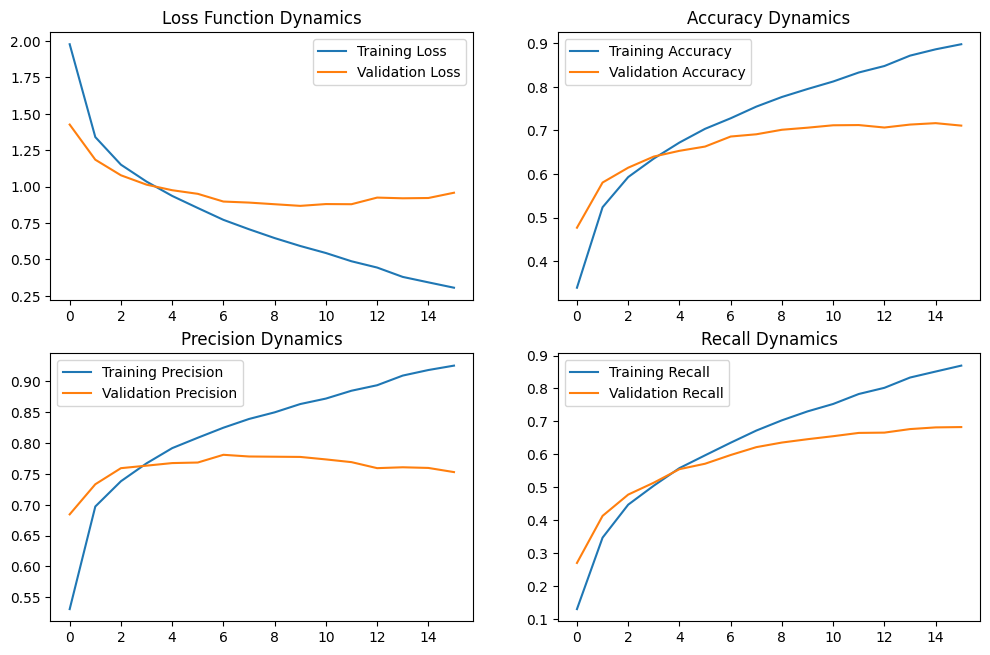

In [31]:
plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(history_2.history['loss'], label='Training Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.title('Loss Function Dynamics')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(history_2.history['accuracy'], label='Training Accuracy')
plt.plot(history_2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Dynamics')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(history_2.history['precision_2'], label='Training Precision')
plt.plot(history_2.history['val_precision_2'], label='Validation Precision')
plt.title('Precision Dynamics')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(history_2.history['recall_2'], label='Training Recall')
plt.plot(history_2.history['val_recall_2'], label='Validation Recall')
plt.title('Recall Dynamics')
plt.legend()

plt.show()


In [32]:
preds = second_model.predict(X_test, verbose=0)
preds = np.argmax(preds, axis=1)
y_test_idx = np.argmax(y_test, axis=1)

print(classification_report(y_test_idx, preds))

              precision    recall  f1-score   support

           0       0.80      0.71      0.75       187
           1       0.88      0.76      0.81       189
           2       0.69      0.56      0.62       201
           3       0.48      0.57      0.52       198
           4       0.62      0.73      0.67       181
           5       0.52      0.67      0.59       191
           6       0.83      0.76      0.79       213
           7       0.86      0.69      0.77       226
           8       0.85      0.86      0.85       203
           9       0.76      0.82      0.79       211

    accuracy                           0.71      2000
   macro avg       0.73      0.71      0.72      2000
weighted avg       0.73      0.71      0.72      2000



# Эксперимент 3

In [33]:
dataset_train_3 = dataset_train.shard(num_shards=10, index=0)

backbone.load_weights('weights/backbone')

inputs = Input(shape=(32, 32, 3))
x = backbone(inputs, training=False)
x = Flatten()(x)
x = Dense(128, activation="relu", name='Dense_1')(x)
x = Dropout(0.25)(x)
output = Dense(10, activation='softmax', name='Output')(x)

In [34]:
third_model = Model(inputs=inputs, outputs=output)

third_model.compile(optimizer=keras.optimizers.Adam(0.0005),
                    loss="categorical_crossentropy",
                    metrics=['accuracy',  # Заменяем F1 на стандартную метрику accuracy
                             keras.metrics.Precision(name='precision_3'),
                             keras.metrics.Recall(name='recall_3')])

learn_rate_red = ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5, min_lr=1e-6)
early_stop = EarlyStopping(monitor="val_loss", patience=6)
tensorboard = TensorBoard(log_dir="logs/Exp_3")

In [35]:
history_3 = third_model.fit(dataset_train_3,
                            validation_data=dataset_valid,
                            epochs=50,
                            callbacks=[learn_rate_red, early_stop, tensorboard])

Epoch 1/50
20/20 [==============================] - 2s 45ms/step - loss: 2.9150 - accuracy: 0.1951 - precision_3: 0.1917 - recall_3: 0.0451 - val_loss: 1.9784 - val_accuracy: 0.2770 - val_precision_3: 0.5298 - val_recall_3: 0.0278 - lr: 5.0000e-04
Epoch 2/50
20/20 [==============================] - 1s 32ms/step - loss: 1.8939 - accuracy: 0.3109 - precision_3: 0.5664 - recall_3: 0.0725 - val_loss: 1.7375 - val_accuracy: 0.3705 - val_precision_3: 0.5947 - val_recall_3: 0.1036 - lr: 5.0000e-04
Epoch 3/50
20/20 [==============================] - 1s 33ms/step - loss: 1.7035 - accuracy: 0.3879 - precision_3: 0.5864 - recall_3: 0.1412 - val_loss: 1.5871 - val_accuracy: 0.4280 - val_precision_3: 0.6267 - val_recall_3: 0.1744 - lr: 5.0000e-04
Epoch 4/50
20/20 [==============================] - 1s 34ms/step - loss: 1.5423 - accuracy: 0.4531 - precision_3: 0.6498 - recall_3: 0.2258 - val_loss: 1.4778 - val_accuracy: 0.4664 - val_precision_3: 0.6705 - val_recall_3: 0.2414 - lr: 5.0000e-04
Epoch 5/

In [36]:
eval_hist_3 = third_model.evaluate(dataset_test)

print(f"Eval_loss = {eval_hist_3[0]}")

print(f"Eval_accuracy = {eval_hist_3[1]}")
print(f"Eval_precision = {eval_hist_3[2]}")
print(f"Eval_recall = {eval_hist_3[3]}")

8/8 [==============================] - 0s 7ms/step - loss: 1.0953 - accuracy: 0.6380 - precision_3: 0.7165 - recall_3: 0.5750
Eval_loss = 1.0952997207641602
Eval_accuracy = 0.6380000114440918
Eval_precision = 0.7165108919143677
Eval_recall = 0.5750000476837158


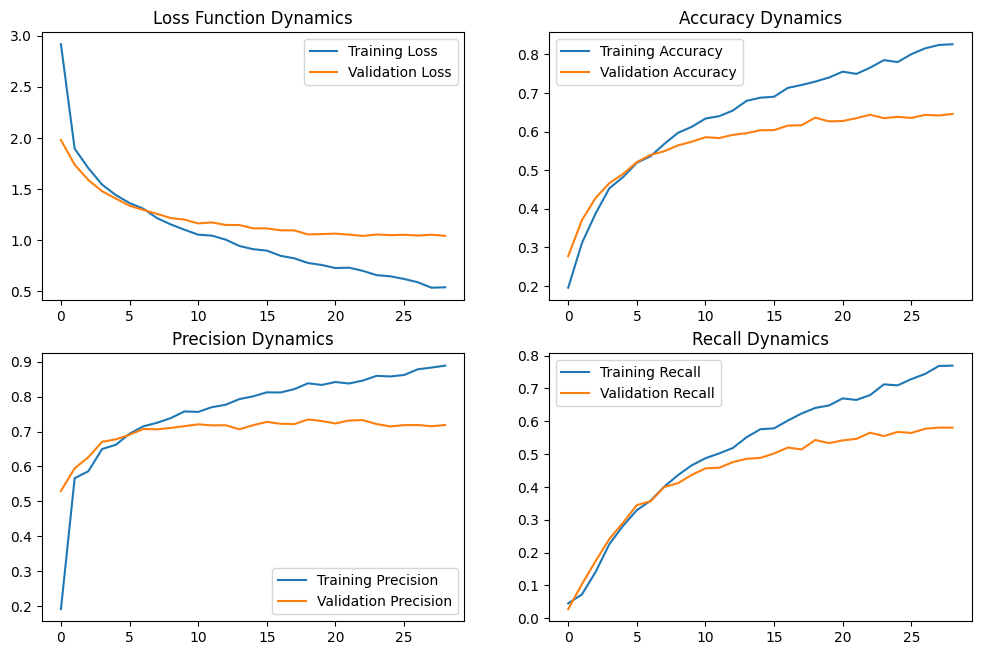

In [37]:
plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(history_3.history['loss'], label='Training Loss')
plt.plot(history_3.history['val_loss'], label='Validation Loss')
plt.title('Loss Function Dynamics')
plt.legend()


plt.subplot(4, 2, 2)
plt.plot(history_3.history['accuracy'], label='Training Accuracy')
plt.plot(history_3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Dynamics')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(history_3.history['precision_3'], label='Training Precision')
plt.plot(history_3.history['val_precision_3'], label='Validation Precision')
plt.title('Precision Dynamics')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(history_3.history['recall_3'], label='Training Recall')
plt.plot(history_3.history['val_recall_3'], label='Validation Recall')
plt.title('Recall Dynamics')
plt.legend()

plt.show()


In [38]:
preds = third_model.predict(X_test, verbose=0)
preds = np.argmax(preds, axis=1)
y_test_idx = np.argmax(y_test, axis=1)

print(classification_report(y_test_idx, preds))

              precision    recall  f1-score   support

           0       0.64      0.76      0.70       187
           1       0.68      0.83      0.74       189
           2       0.48      0.52      0.50       201
           3       0.42      0.39      0.41       198
           4       0.60      0.52      0.56       181
           5       0.54      0.55      0.54       191
           6       0.64      0.72      0.68       213
           7       0.82      0.67      0.74       226
           8       0.81      0.73      0.77       203
           9       0.79      0.66      0.72       211

    accuracy                           0.64      2000
   macro avg       0.64      0.64      0.64      2000
weighted avg       0.65      0.64      0.64      2000



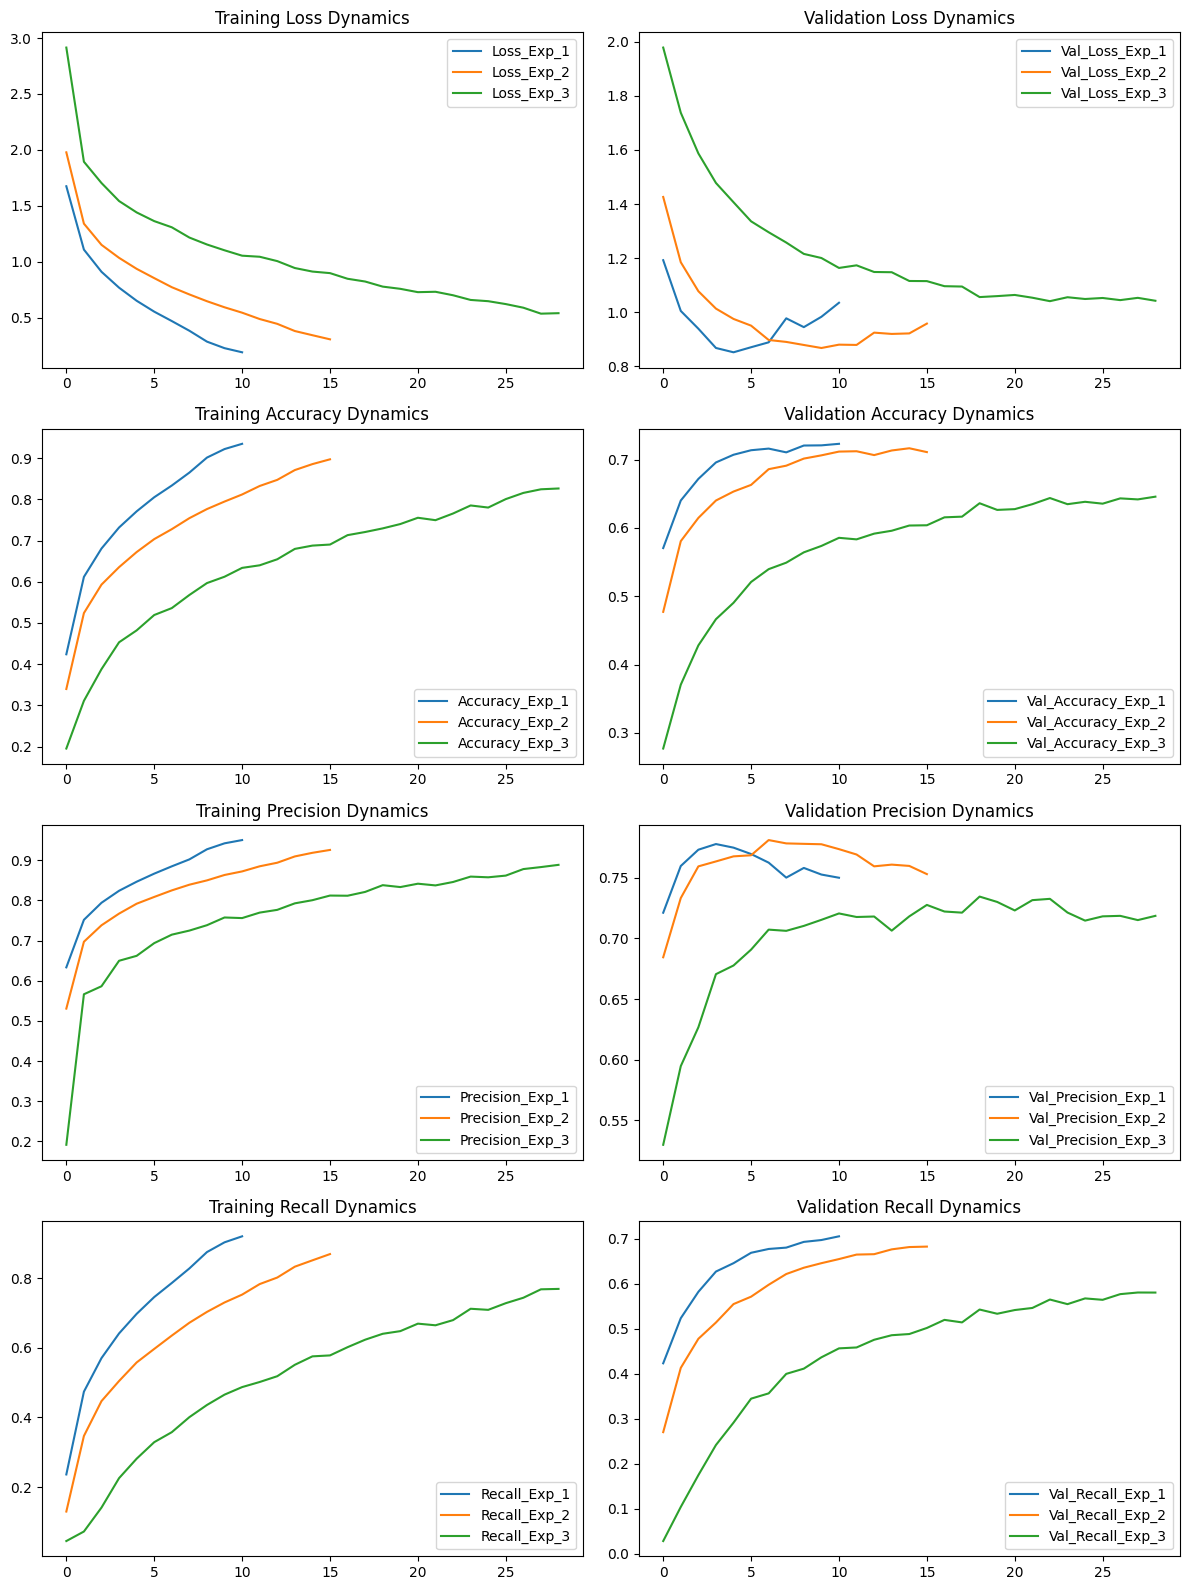

In [41]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(history_1.history['loss'], label='Loss_Exp_1')
plt.plot(history_2.history['loss'], label='Loss_Exp_2')
plt.plot(history_3.history['loss'], label='Loss_Exp_3')
plt.title('Training Loss Dynamics')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(history_1.history['val_loss'], label='Val_Loss_Exp_1')
plt.plot(history_2.history['val_loss'], label='Val_Loss_Exp_2')
plt.plot(history_3.history['val_loss'], label='Val_Loss_Exp_3')
plt.title('Validation Loss Dynamics')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(history_1.history['accuracy'], label='Accuracy_Exp_1')
plt.plot(history_2.history['accuracy'], label='Accuracy_Exp_2')
plt.plot(history_3.history['accuracy'], label='Accuracy_Exp_3')
plt.title('Training Accuracy Dynamics')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(history_1.history['val_accuracy'], label='Val_Accuracy_Exp_1')
plt.plot(history_2.history['val_accuracy'], label='Val_Accuracy_Exp_2')
plt.plot(history_3.history['val_accuracy'], label='Val_Accuracy_Exp_3')
plt.title('Validation Accuracy Dynamics')
plt.legend()

plt.subplot(4, 2, 5)
plt.plot(history_1.history['precision_1'], label='Precision_Exp_1')
plt.plot(history_2.history['precision_2'], label='Precision_Exp_2')
plt.plot(history_3.history['precision_3'], label='Precision_Exp_3')
plt.title('Training Precision Dynamics')
plt.legend()

plt.subplot(4, 2, 6)
plt.plot(history_1.history['val_precision_1'], label='Val_Precision_Exp_1')
plt.plot(history_2.history['val_precision_2'], label='Val_Precision_Exp_2')
plt.plot(history_3.history['val_precision_3'], label='Val_Precision_Exp_3')
plt.title('Validation Precision Dynamics')
plt.legend()

plt.subplot(4, 2, 7)
plt.plot(history_1.history['recall_1'], label='Recall_Exp_1')
plt.plot(history_2.history['recall_2'], label='Recall_Exp_2')
plt.plot(history_3.history['recall_3'], label='Recall_Exp_3')
plt.title('Training Recall Dynamics')
plt.legend()

plt.subplot(4, 2, 8)
plt.plot(history_1.history['val_recall_1'], label='Val_Recall_Exp_1')
plt.plot(history_2.history['val_recall_2'], label='Val_Recall_Exp_2')
plt.plot(history_3.history['val_recall_3'], label='Val_Recall_Exp_3')
plt.title('Validation Recall Dynamics')
plt.legend()

plt.tight_layout()  
plt.show()  


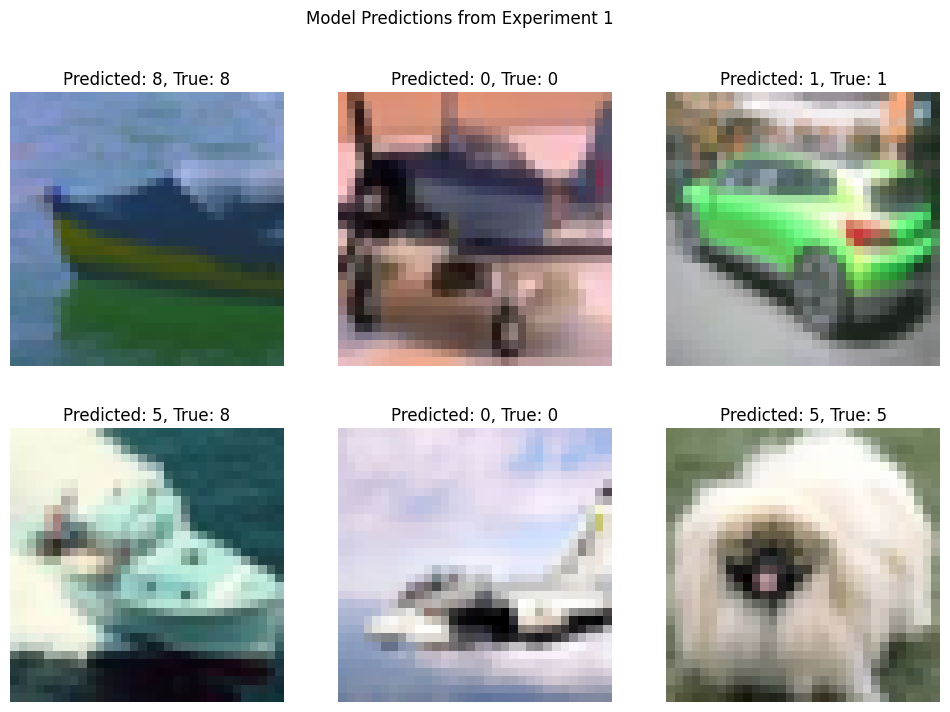

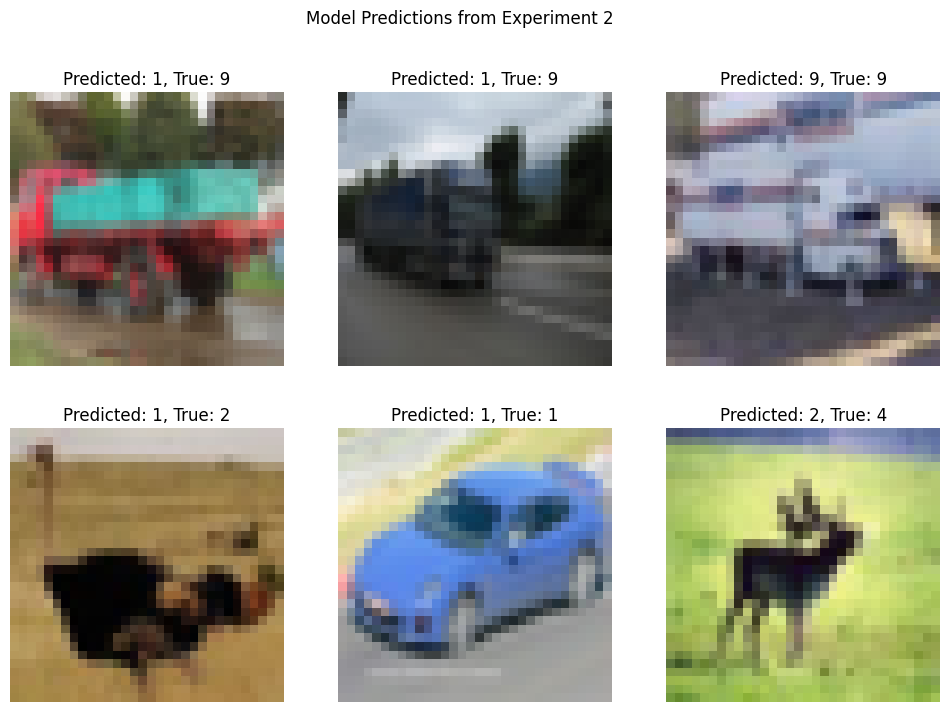

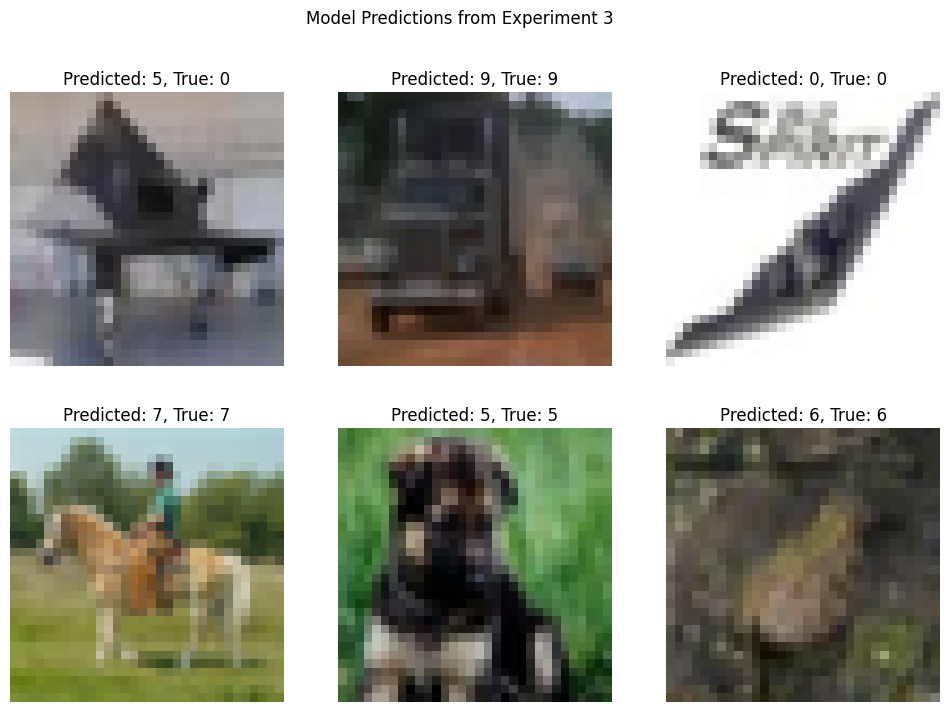

In [42]:
def visualize_model_predictions(model, X_test, y_test, title):
    h, w = (2, 3)
    fig, axs = plt.subplots(h, w, figsize=(12, 8))
    fig.suptitle(title)
    for i in range(h):
        for j in range(w):
            num = np.random.randint(len(X_test))
            pred = model.predict(np.expand_dims(X_test[num], axis=0), verbose=0)
            pred_class = np.argmax(pred, axis=1)[0]
            true_class = np.argmax(y_test[num])
            axs[i, j].imshow(X_test[num])
            axs[i, j].set_title(f'Predicted: {pred_class}, True: {true_class}')
            axs[i, j].axis('off')

visualize_model_predictions(first_model, X_test, y_test, 'Model Predictions from Experiment 1')
visualize_model_predictions(second_model, X_test, y_test, 'Model Predictions from Experiment 2')
visualize_model_predictions(third_model, X_test, y_test, 'Model Predictions from Experiment 3')

plt.show()
